# Tree QA: Model Comparison and Error Analysis

Evaluates language models on natural language questions about tree structures. Responses are compared to ground truth, and error patterns are visualized using heatmaps.

In [26]:
import os
import csv
import dotenv
import time
import pathlib
from collections import defaultdict
from tqdm.notebook import tqdm
import seaborn
import pandas
from matplotlib import pyplot as plt
from llm_comparison.llm_api import ask_model

In [2]:
dotenv.load_dotenv()

True

In [3]:
API_KEY = os.getenv('OPENROUTER_API_KEY')
BASE_URL = "https://openrouter.ai/api/v1/chat/completions"

In [4]:
headers = {
    "Authorization": f"Bearer {API_KEY}",
    "Content-Type": "application/json"
}

In [5]:
free_models = [
    "anthropic/claude-sonnet-4",
    "google/gemini-2.0-flash-001",
]

In [6]:
prompt = "What is 11 + 1? Answer with only the number, no explanation."
results = []

for model in free_models:
    print(f"\nTesting: {model}")
    response = ask_model(prompt, model, BASE_URL, headers)
    print(f"Response: {response}")
    
    results.append({
        'model': model,
        'response': response
    })


Testing: anthropic/claude-sonnet-4
Response: 12

Testing: google/gemini-2.0-flash-001
Response: 12


Load data and send queries to models.

In [10]:
def load_dataset_from_csv(csv_path: pathlib.Path):
    dataset = defaultdict(list)  # key: (size, density), value: list of QAExample-like dicts
    with open(csv_path, encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            size = int(row['size'])
            density = float(row['density'])
            dataset[(size, density)].append({
                'text': row['text'],
                'query': row['query'],
                'answer': row['answer'],
            })
    return dataset

In [11]:
dataset = load_dataset_from_csv(pathlib.Path("../data/qa_dataset.csv"))

In [14]:
results = dict()
for model in free_models:
    print(f"{model} is testing")
    results[model] = defaultdict(list)
    tree_requests_results = results[model]
    request_count = 0
    for (size, density), qa_samples in tqdm(dataset.items()):
        for qa_sample in qa_samples:
            prompt = f"{qa_sample['text']} {qa_sample['query']}"
            response = ask_model(prompt, model, BASE_URL, headers)
            tree_requests_results[(size, density)].append((response, qa_sample['answer']))
            request_count += 1
            if request_count % 10 == 0:
                print(f"[{request_count}] Query: {qa_sample['query']}")
                print(f"Response: {response}")
                print(f"Answer: {qa_sample['answer']}")
            time.sleep(3)


anthropic/claude-sonnet-4 is testing


  0%|          | 0/117 [00:00<?, ?it/s]

[10] Query: Who is lowest (youngest) common ancestor for Aaron and Abigail? Only name, one name, nothing else.
Response: Adam
Answer: Adam
[20] Query: Who is lowest (youngest) common ancestor for Aaron and Aaron? Only name, one name, nothing else.
Response: Aaron
Answer: Aaron
[30] Query: Who is lowest (youngest) common ancestor for Aaron and Adrian? Only name, one name, nothing else.
Response: Adrian
Answer: Adrian
[40] Query: Who is lowest (youngest) common ancestor for Adam and Abigail? Only name, one name, nothing else.
Response: Adriana
Answer: Adriana
[50] Query: Who is lowest (youngest) common ancestor for Adam and Adam? Only name, one name, nothing else.
Response: Adam
Answer: Adam
[60] Query: Who is lowest (youngest) common ancestor for Adrian and Alan? Only name, one name, nothing else.
Response: Alan
Answer: Alan
[70] Query: Who is lowest (youngest) common ancestor for Adriana and Adriana? Only name, one name, nothing else.
Response: Adriana
Answer: Adriana
[80] Query: Who i

  0%|          | 0/117 [00:00<?, ?it/s]

[10] Query: Who is lowest (youngest) common ancestor for Aaron and Abigail? Only name, one name, nothing else.
Response: Adam
Answer: Adam
[20] Query: Who is lowest (youngest) common ancestor for Aaron and Aaron? Only name, one name, nothing else.
Response: Adam
Answer: Aaron
[30] Query: Who is lowest (youngest) common ancestor for Aaron and Adrian? Only name, one name, nothing else.
Response: Adriana
Answer: Adrian
[40] Query: Who is lowest (youngest) common ancestor for Adam and Abigail? Only name, one name, nothing else.
Response: Adriana
Answer: Adriana
[50] Query: Who is lowest (youngest) common ancestor for Adam and Adam? Only name, one name, nothing else.
Response: Adriana
Answer: Adam
[60] Query: Who is lowest (youngest) common ancestor for Adrian and Alan? Only name, one name, nothing else.
Response: Albert
Answer: Alan
[70] Query: Who is lowest (youngest) common ancestor for Adriana and Adriana? Only name, one name, nothing else.
Response: Albert
Answer: Adriana
[80] Query: W

Saving all of the results in CSV

In [36]:
def save_llm_results(results: dict, path: str) -> None:
    with open(path, mode='w', newline='', encoding='utf-8') as f:
        writer = csv.writer(f)
        writer.writerow(['model', 'size', 'density', 'response', 'answer'])
        for model, data in results.items():
            for (size, density), pairs in data.items():
                for response, answer in pairs:
                    writer.writerow([model, size, density, response, answer])


In [37]:
save_llm_results(results, "../data/llm_responses.csv")

In [38]:
def load_llm_results(path: str) -> dict:
    results = defaultdict(lambda: defaultdict(list))
    with open(path, newline='', encoding='utf-8') as f:
        reader = csv.DictReader(f)
        for row in reader:
            model = row['model']
            size = int(row['size'])
            density = float(row['density'])
            response = row['response']
            answer = row['answer']
            results[model][(size, density)].append((response, answer))
    return results


In [39]:
_results = load_llm_results("../data/llm_responses.csv")

In [40]:
tree_requests_error = dict()
for model in free_models:
    tree_requests_error[model] = dict()
    for k, v in _results[model].items():
        if "Error: 402" in [response for response, _ in v] or any(len(response) > 50 for response, _ in v):
            tree_requests_error[model][k] = None
        else:
            tree_requests_error[model][k] = sum(response == answer for response, answer in v) / len(v)


In [41]:
dataframes = dict()
for model in free_models:
    df = pandas.DataFrame(
        {(size, density): value for (size, density), value in tree_requests_error[model].items()},
        index=[0]
    ).T.reset_index()
    df.columns = ['size', 'density', 'value']
    heatmap_data = df.pivot(index='density', columns='size', values='value')
    dataframes[model] = (df, heatmap_data)

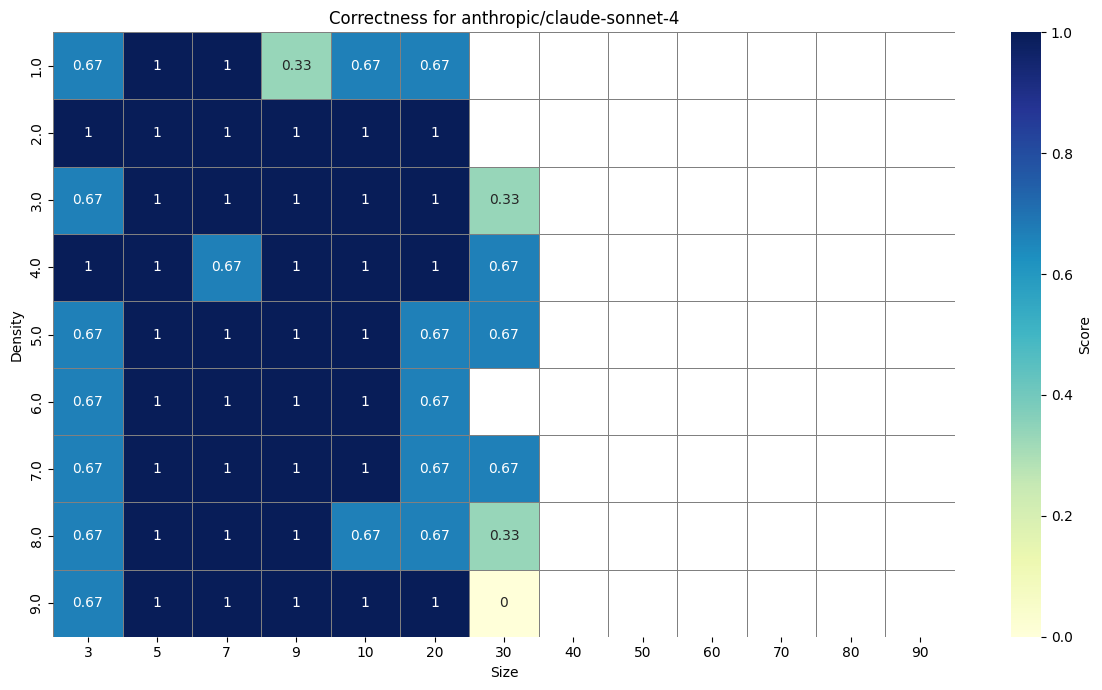

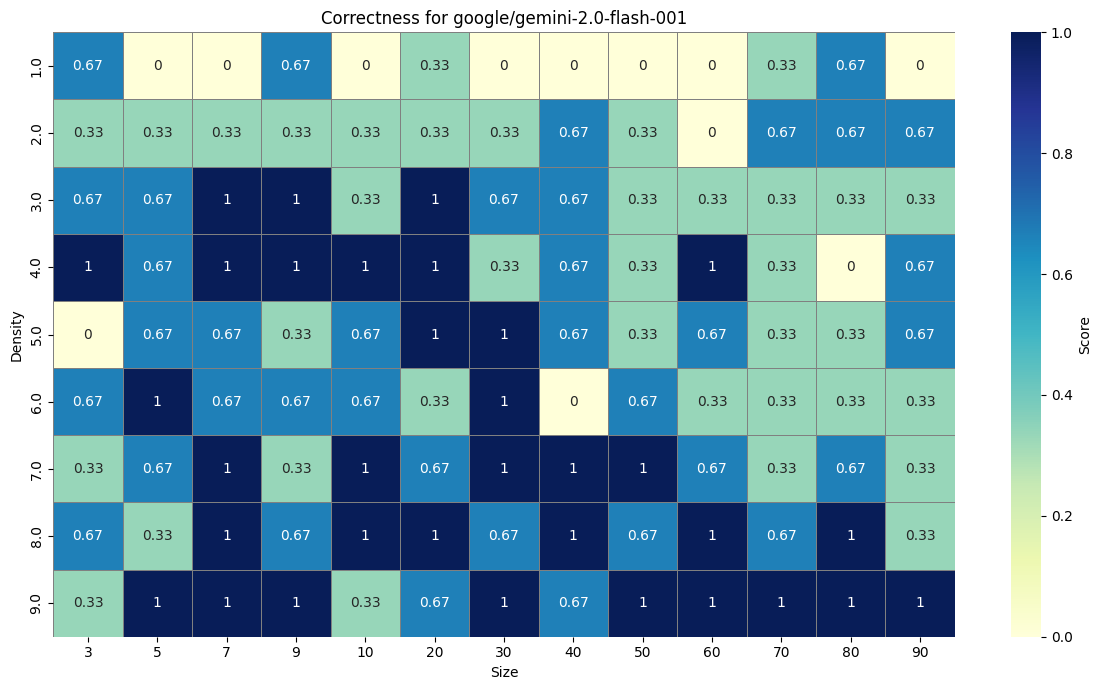

In [42]:
for model in free_models:
    df, heatmap_data = dataframes[model]
    df['value'] = pandas.to_numeric(df['value'], errors='coerce')
    heatmap_data = df.pivot(index='density', columns='size', values='value')
    plt.figure(figsize=(12, 7))
    seaborn.heatmap(
        heatmap_data, 
        annot=True, 
        cmap="YlGnBu", 
        vmin=0, vmax=1, 
        cbar_kws={'label': 'Score'},
        linewidths=0.5, 
        linecolor='gray'
    )
    plt.title(f'Correctness for {model}')
    plt.xlabel('Size')
    plt.ylabel('Density')
    plt.tight_layout()
    plt.show()
